
# Clustering documents, modeling topics and generating text recommendations:


## A Natural Language Processing approach using the Edgar Allan Poe's corpus of short stories


<img src=" https://storage.googleapis.com/kagglesdsdata/datasets%2F893618%2F1516276%2Fpoe.png?GoogleAccessId=databundle-worker-v2@kaggle-161607.iam.gserviceaccount.com&Expires=1601537101&Signature=Jd9JyOxwEkZQMpd7bRUXaimp4UJqcgARpWX0QmjHWYcqsVbr%2BJvLOq1Wcir6315AshMBWMjM9SU0710qBBZgLgZNIx1C4nNCl97ZhNdZnJZe6TEUjPGkuKyOarqpBzOx9wDGgu7zya6%2BsmMlI6pjvxoILQOq%2B%2FXfJru2BprUrMuij52b6dua6rMCGD9EmNBZGYqpzCR21PCuRgHxmcWqE0y16ewQaZgHg2fjj6L%2B9womOLJfKuY1yperlmxV56OLl%2BpqNmhsucQgt8esaW5I5OiLgQgptRAF380v%2B%2Brh3iYFmlpWDhNHa3szGs1w2bWgzo78fnUds0Xnf8PVW6dP8w%3D%3D" width="400px">



## <ins> Poe's corpus in context </ins>

Edgar Allan Poe was an American short story writer, poet and critic, born in Boston in 1809. His short stories encompassed several topics: detective fiction (he is the creator of the modern detective fiction genre), science fiction, horror and humor. Poe's narratives are often envolved with the characteristic aesthetic of the Romantic movement (present in classical books of the same era, such as Frankenstein or Dracula).


## <ins> Methods </ins>

In this notebook, I will explore the Poe's corpus of 70 short stories to perform several actions:


- To find hidden relations among elements of the corpus, based on semantics and style <span style="color:green">-> Word2vec </span>

- To elaborate a document level (i.e., "story-level") classification <span style="color:green">-> cosine-similarity of the Word2vec matrix + clustering </span>

- To tag each document with 5-10 main topics  <span style="color:green">-> Latent Dirichlet Allocation, mediated by some optimization </span>

- To generate a simple recommender system. For example, if I read one of the stories and I liked it... which story could I pick next based on this preference? <span style="color:green">-> Analyzing with KNN the Word2vec matrix </span>



## <ins>Data source</ins>

- Edgar Allan Poe's corpus of short stories, available as raw HTML at Project Gutenberg<sup>1</sup>:
http://www.gutenberg.org/files/25525/25525-h/25525-h.htm#2150link2H_4_0003

### -> You can find a processed version of the generated dataset attached to this kernel for your own experiments! <- 
[](http://)

- A table from Wikipedia with information about the stories: https://en.wikipedia.org/wiki/Edgar_Allan_Poe_bibliography 
The information was merged with the Project Gutenberg data.


In [1]:
%%capture

!pip install contractions
!pip install gensim

import html
import re
import unicodedata
import string
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import contractions
import numpy as np
import os
import datetime
import seaborn as sns
import multiprocessing
import nltk
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim  

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from requests import get
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, ward, cut_tree
from gensim import corpora, models
from gensim.models import word2vec
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from collections import Counter
from sklearn.manifold import TSNE

pd.set_option('display.max_rows', 10)

nltk.download('stopwords')
spacy.cli.download("en")

sns.set(style="darkgrid")
%matplotlib inline

# 1. Preprocessing the downloaded webpage with Poe's stories / curating the Wikipedia information

## jump to <span style="color:blue">Section 2</span> in case you are only interested in the analysis! The goal of <span style="color:blue">Section 1</span> is to make the workflow fully reproducible

In [2]:
url = 'http://www.gutenberg.org/files/25525/25525-h/25525-h.htm#2150link2H_4_0003'
response = get(url)
response.encoding = 'utf-8'

text = re.sub(r"\r|\n", "", response.text)
book1 = re.search(r"<h2[^<]*?THE UNPARALLELED ADVENTURES.*She was dead!.*?p>", text).group(0)
book2 = re.search(r"<h2[^<]*?THE PURLOINED LETTER.*unto Eleonora.*?p>", text).group(0)
book3 = re.search(r"<h2[^<]*?LIGEIA.*opinion upon that.*?p>", text).group(0)
book4 = re.search(r"<h2[^<]*?THE DEVIL IN THE BELFRY.*departed friends.*?p>", text).group(0)
book5 = re.search(r"<h2[^<]*?PHILOSOPHY OF FURNITURE.*it would have been Lilies without, roses within.*?p>", text).group(0)

books = book1 + book2 + book3 + book4 + book5
books = html.unescape(books)
books = re.sub(r"\s+", " ", books)

## Obtaining the titles

In [3]:
titles = re.findall(r"<h2.*?h2>", books)
titles = [re.sub(r"<.*?>", "", x).strip() for x in titles]
titles = [re.sub(r"Footnotes.*|Notes.*|[.]|\(.*?\)", "",x, flags=re.I) for x in titles]
titles = [x.strip() for x in titles if x != ""]
sort_index = np.argsort(titles)
titles = np.array(titles)[sort_index]
pd.DataFrame({"Titles":titles}).head(5)

,Titles
0,* PHILOSOPHY OF FURNITURE
1,A DESCENT INTO THE MAELSTRÖM
2,A PREDICAMENT
3,A TALE OF JERUSALEM
4,A TALE OF THE RAGGED MOUNTAINS


## Sorting the stories using the title order

In [4]:
stories = books.split("<h2>")
stories = [re.sub(r"^.*</h2>","", x) for x in stories]
stories = [re.sub(r"<.*?>","", x).strip() for x in stories]
stories = [i for i in stories if i != "" and re.match(r"\(\*1\)", i) is None]
stories = np.array(stories)[sort_index]
print("Number of stories : %s, Number of titles : %s" %(len(stories),len(titles)))

Number of stories : 70, Number of titles : 70


## Gathering bibliographic information from Wikipedia

In [5]:
tables = pd.read_html("https://en.wikipedia.org/wiki/Edgar_Allan_Poe_bibliography", header=0)
table = tables[2].sort_values(by="Title")
table.Notes =  [re.sub(r'\[.*\]', "", x) for x in table.Notes.values]
table[:5]

/opt/conda/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


,Title,Publication date,First published in,Genre,Notes
28,"""A Descent into the Maelström""",May 1841,Graham's Magazine,Adventure,
18,"""A Predicament""",November 1838,Baltimore American Museum,Parody,"Companion to ""How to Write a Blackwood Article..."
2,"""A Tale of Jerusalem""","June 9, 1832",Philadelphia Saturday Courier,Humor,
44,"""A Tale of the Ragged Mountains""",April 1844,Godey's Lady's Book,"Science fiction, Adventure",
7,"""Berenice""",March 1835,Southern Literary Messenger,Horror,


## Wikipedia information formatting. Matching this table with the titles of the data downloaded from Project Gutenberg. For each title, extract genre and date from the table of Wikipedia

In [6]:
titles2 = [x.upper() for x in table.Title.values.tolist()]
titles2 = np.array([re.sub("[^A-Z]", "", x) for x in titles2])
titles1 = np.array([re.sub("[^A-Z]", "", x) for x in titles])
table_info_subs = [True if x in titles1 else False for x in titles2]
subs = np.array([True if x in titles2 else False for x in titles1])
table = table[table_info_subs]
titles2 = titles2[table_info_subs]
sort_index = np.argsort(titles2)
table = table.iloc[sort_index,:]
titles2 = titles2[sort_index]

titles_not_in_wiki = titles[~subs]
stories_not_in_wiki = stories[~subs]
titles = titles[subs]
stories = stories[subs]
sort_index = np.argsort(titles)
titles = np.array(titles)[sort_index]
stories = stories[sort_index]


titles = np.concatenate((titles, titles_not_in_wiki), axis = 0)
stories = np.concatenate((stories, stories_not_in_wiki), axis = 0)


## Final dataset: 62 annotated documents + 8 unannotated documents

In [7]:
data = pd.DataFrame({"title": titles, "stories":stories})
table = table.reset_index(drop= True)
data = data.join(table, how="left")
data.columns = ["title", "text", "wikipedia_title", "publication_date", "first_published_in", "classification", "notes"]
data.fillna("", inplace = True)
data[:5]

,title,text,wikipedia_title,publication_date,first_published_in,classification,notes
0,A DESCENT INTO THE MAELSTRÖM,"The ways of God in Nature, as in Providence, a...","""A Descent into the Maelström""",May 1841,Graham's Magazine,Adventure,
1,A PREDICAMENT,"What chance, good lady, hath bereft you thus? ...","""A Predicament""",November 1838,Baltimore American Museum,Parody,"Companion to ""How to Write a Blackwood Article..."
2,A TALE OF JERUSALEM,Intensos rigidarn in frontern ascendere canos ...,"""A Tale of Jerusalem""","June 9, 1832",Philadelphia Saturday Courier,Humor,
3,A TALE OF THE RAGGED MOUNTAINS,"DURING the fall of the year 1827, while residi...","""A Tale of the Ragged Mountains""",April 1844,Godey's Lady's Book,"Science fiction, Adventure",
4,BERENICE,"Dicebant mihi sodales, si sepulchrum amicae vi...","""Berenice""",March 1835,Southern Literary Messenger,Horror,


## Completing missing data

In [8]:
# PHILOSOPHY OF FURNITURE
## https://en.wikipedia.org/wiki/The_Philosophy_of_Furniture
data.at[62,'classification']= 'Essay'
data.at[62,'publication_date']= 'May 1840'

# MAAELZEL’S CHESS-PLAYER
## https://en.wikipedia.org/wiki/Maelzel%27s_Chess_Player
data.at[63,'classification']= 'Essay'
data.at[63,'publication_date']= 'April 1836'

# OLD ENGLISH POETRY
data.at[64,'classification']= 'Essay'
data.at[64,'publication_date']= "?"

# THE BALLOON-HOAX
## https://en.wikipedia.org/wiki/The_Balloon-Hoax
data.at[65,'classification']= 'Hoax / Fiction'
data.at[65,'publication_date']= 'April 13, 1844'

# THE MYSTERY OF MARIE ROGET
## https://en.wikipedia.org/wiki/The_Mystery_of_Marie_Rog%C3%AAt
## taking the date of publication of the first part
data.at[66,'classification']= 'Detective fiction'
data.at[66,'publication_date']= 'November 1842'

# THE POETIC PRINCIPLE
## http://www.thepoeblog.org/the-poetic-principle-a-rich-intellectual-treat/
## taking the date when the the work was known with Poe alive (published posthumously)
data.at[67,'classification']= 'Essay'
data.at[67,'publication_date']= 'August 17, 1849' 

# THE UNPARALLELED ADVENTURES OF ONE HANS PFAAL
## https://en.wikipedia.org/wiki/The_Unparalleled_Adventure_of_One_Hans_Pfaall
data.at[68,'classification']= 'Hoax / Science fiction'
data.at[68,'publication_date']= 'June 1835' 

# X-ING A PARAGRAPH
data.at[69,'classification']= 'Satire'
data.at[69,'publication_date']= 'May 12, 1849' 

# Some fixes 
## The Purloined Letter
## https://en.wikipedia.org/wiki/The_Purloined_Letter
data.at[51,'publication_date']= "December, 1844"

## Silence - a Fable
## https://en.wikipedia.org/wiki/Poems_by_Edgar_Allan_Poe
data.at[23,'publication_date']= "January 4, 1840"

## https://www.goodreads.com/book/show/8498298-why-the-little-frenchman-wears-his-hand-in-a-sling
data.at[60,'publication_date']= "August 17, 1839"

# Eleonora
## Unknown month, published in "the Gift" as "The Pit and the Pendulum"
data.at[6,'publication_date']= "? 1841"

# The Pit and the Pendulum
data.at[48,'publication_date']= "? 1843"

## Date normalization

In [9]:
year = [re.sub(r"(.*)(\d{4})", "\\2", x) for x in  data.publication_date.values]
month = [re.sub(r"[^a-zA-Z]", "", x) for x in  data.publication_date.values]
month[6] = "?"
month[48] = "?"
data["normalized_date"] = ["%s %s" %(x, y) for x,y in zip(month,year)]

## Wikipedia title normalization

In [10]:
data["wikipedia_title"] = [re.sub(r"[\"]", "", x) for x in data.iloc[:,2].values]

## Normalizing the classification column to generate unique, sorted categories

In [11]:
data.classification = [re.sub(",", "/", x) for x in data.classification]
data.classification = [re.sub(r"(\w)( +)(/)", "\\1/", x) for x in data.classification]
data.classification = [re.sub(r"(/)( +)(\w)", "/\\3", x) for x in data.classification]
data.classification = [re.sub(" +", "_", x) for x in data.classification]

tokens = [x.split("/") for x in data.classification.values]
tokens = [sorted(x) for x in tokens]
tokens = [",".join(x) for x in tokens]

data.classification = tokens

np.unique(tokens)

array(['Adventure', 'Adventure,Science_fiction', 'Detective_fiction',
       'Detective_fiction,Satire', 'Essay', 'Fantasy', 'Fantasy,Horror',
       'Fiction,Hoax', 'Hoax,Horror,Science_fiction', 'Hoax,Satire',
       'Hoax,Science_fiction', 'Horror', 'Horror,Humor',
       'Horror,Ratiocination', 'Horror,Satire', 'Humor', 'Humor,Satire',
       'Parody', 'Romance', 'Satire', 'Science_fiction', 'Sketch'],
      dtype='<U27')

## NaN fill with "?"

In [12]:
data[data == ""] = "?"

In [13]:
data.to_csv("preprocessed_data.csv", index=False)
with pd.option_context('display.max_rows', 100):
    display(data)

,title,text,wikipedia_title,publication_date,first_published_in,classification,notes,normalized_date
0,A DESCENT INTO THE MAELSTRÖM,"The ways of God in Nature, as in Providence, a...",A Descent into the Maelström,May 1841,Graham's Magazine,Adventure,?,May 1841
1,A PREDICAMENT,"What chance, good lady, hath bereft you thus? ...",A Predicament,November 1838,Baltimore American Museum,Parody,"Companion to ""How to Write a Blackwood Article...",November 1838
2,A TALE OF JERUSALEM,Intensos rigidarn in frontern ascendere canos ...,A Tale of Jerusalem,"June 9, 1832",Philadelphia Saturday Courier,Humor,?,June 1832
3,A TALE OF THE RAGGED MOUNTAINS,"DURING the fall of the year 1827, while residi...",A Tale of the Ragged Mountains,April 1844,Godey's Lady's Book,"Adventure,Science_fiction",?,April 1844
4,BERENICE,"Dicebant mihi sodales, si sepulchrum amicae vi...",Berenice,March 1835,Southern Literary Messenger,Horror,?,March 1835
5,DIDDLING,CONSIDERED AS ONE OF THE EXACT SCIENCES. He...,Diddling,"October 14, 1843",Philadelphia Saturday Courier,Parody,"Originally ""Raising the Wind; or, Diddling Con...",October 1843
6,ELEONORA,Sub conservatione formae specificae salva anim...,Eleonora,? 1841,The Gift for 1842,Romance,?,? 1841
7,FOUR BEASTS IN ONE—THE HOMO-CAMELEOPARD,Chacun a ses vertus. —Crebillon’s Xerxes. ANT...,Four Beasts in One—The Homo-Cameleopard,March 1836,Southern Literary Messenger,Humor,"Originally ""Epimanes""",March 1836
8,HOP-FROG,I never knew anyone so keenly alive to a joke ...,Hop-Frog,"March 17, 1849",Flag of Our Union,Horror,"Subtitled ""Or, The Eight Chained Ourang-Outangs""",March 1849
9,HOW TO WRITE A BLACKWOOD ARTICLE,“In the name of the Prophet—figs!!” Cry of the...,How to Write a Blackwood Article,November 1838,Baltimore American Museum,Parody,"An introduction to ""A Predicament""",November 1838


# 2. Basic functions

In [14]:

"""
Text normalization
"""

def text_normalizer(text, stemming = False, lemmatize = True,
                    find_bigrams = True, min_count = 2, min_token_length = 2):
  
    # remove dialog marks
    text = re.sub("—+", " ", text)
    # remove accents
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8') 
 
    # fix contractions
    text = contractions.fix(text) 
  
    # fix case
    text = text.lower() 
  
    # remove extra newlines
    text = re.sub(r'[\r|\n|\r\n]+', '\n', text) 
  
    # remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) 
  
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    
    tokens = word_tokenize(text)
  
    stopwords_list = nltk.corpus.stopwords.words('english')
    stopwords_list = stopwords_list + list(string.punctuation)
    stopwords_list = set(stopwords_list)
    tokens = [token.strip() for token in tokens]
    tokens = [token for token in tokens if token not in stopwords_list]

    if stemming:
        stemmer = SnowballStemmer("english")
        tokens = [stemmer.stem(token) for token in tokens]
    
    if lemmatize:
        tag_map = defaultdict(lambda : wn.NOUN)
        tag_map['J'] = wn.ADJ
        tag_map['V'] = wn.VERB
        tag_map['R'] = wn.ADV
    
        wordnet_lemmatizer = WordNetLemmatizer()
        tokens = [wordnet_lemmatizer.lemmatize(token,  tag_map[tag[0]]) for token,tag in pos_tag(tokens)]

    tokens = [token for token in tokens if len(token) > min_token_length]
  
    return tokens


"""
Computation of Word2vec average vectors
"""

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features, ), dtype = "float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector
  
    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

"""
LDA Coherence computation
"""

def compute_coherence_values(model, dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("Modeling = " + str(num_topics))
        model = models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word = dictionary, 
                                         passes=20, random_state = 100, 
                                         alpha='auto', eta='auto', update_every=1, chunksize=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherencemodel.get_coherence()
        coherence_values.append(coherence)
        print("Coherence: " + str(coherence))
    return model_list, coherence_values


def plot_coherence(coherence_values, start, limit, step):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    
"""
Genererate a table output with the LDA results
"""
    
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# 3. Text normalization and creation of word embeddings 

In [15]:
normalized_stories = [text_normalizer(i) for i in data.text.values]

## Word count

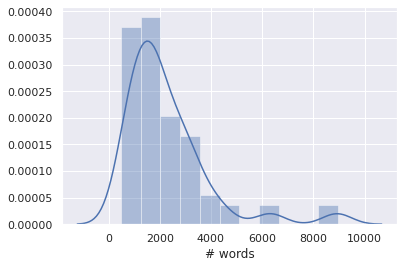

In [16]:
sns.distplot([len(x) for x in normalized_stories], axlabel="# words")

In [17]:
# Set values for various parameters
feature_size = 300 # Word vector dimensionality
window_context = 20 # Context window size
min_word_count = 3 # Minimum word count
sample = 6e-5 # Downsample setting for frequent words
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
negative = 10
alpha = 0.03
epochs = 300
min_alpha =  0.03 / epochs #alpha - (min_alpha * epochs) ~ 0.00

bigram = Phrases(normalized_stories, min_count=5, delimiter=b' ')
bigram_text = [bigram[line] for line in normalized_stories]

w2v_model = word2vec.Word2Vec(size=feature_size, window=window_context, min_count=min_word_count, 
                              sample=sample, iter=epochs, workers=cores-1, negative = negative, 
                              alpha = alpha, min_alpha = min_alpha)

w2v_model.build_vocab(bigram_text)

w2v_model.train(normalized_stories, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)


(8829438, 15855100)

In [18]:
w2v_model.corpus_total_words

154554

## Get document-level embeddings

In [19]:
w2v_feature_array = averaged_word_vectorizer(corpus=normalized_stories, model=w2v_model, num_features=feature_size)
corpus_df = pd.DataFrame(w2v_feature_array)

## Words "similar" to "Dupin"?

In [20]:
w2v_model.most_similar(positive=["dupin"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('prefect', 0.7804126739501953),
 ('meerschaum', 0.6897088289260864),
 ('purloin', 0.6037864089012146),
 ('document', 0.563034176826477),
 ('minister', 0.5427200794219971),
 ('mystery', 0.5391501188278198),
 ('imprison', 0.522384762763977),
 ('insoluble', 0.5176173448562622),
 ('functionary', 0.499724805355072),
 ('parisian', 0.4978931248188019)]

## And what about "clock"?

In [21]:
w2v_model.most_similar(positive=["clock"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('twelve', 0.5752464532852173),
 ('eleven', 0.5411689281463623),
 ('nine', 0.5259519815444946),
 ('steeple', 0.5219655632972717),
 ('watch', 0.5139842629432678),
 ('chime', 0.5019042491912842),
 ('appointment', 0.5009873509407043),
 ('seven', 0.4881994426250458),
 ('ceased', 0.4776472747325897),
 ('ten', 0.4759809076786041)]

## And what happens with "poetry"?

In [22]:
w2v_model.most_similar(positive=["poetry"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('poetical', 0.741775393486023),
 ('poetic', 0.7207741737365723),
 ('poems', 0.6921539306640625),
 ('bard', 0.6160850524902344),
 ('poet', 0.6100533604621887),
 ('poem', 0.6090166568756104),
 ('sentiment', 0.5985633134841919),
 ('rhythm', 0.5807971954345703),
 ('artistic', 0.5742201209068298),
 ('supernal', 0.5639057755470276)]

# 4. Visualization of results

## Let' cluster the stories, to detect interrelations based on text. I am grouping similar genres (e.g., humor = humor + satire + parody) for visualization purposes

In [23]:
similarity_matrix = cosine_similarity(w2v_feature_array)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df
Z = linkage(similarity_matrix, 'ward')

labels = data.classification.values

classes=np.unique(labels)
classes = [re.sub(".*Horror.*", "Horror", x) for x in classes]
classes = [re.sub(".*Humor.*", "Humor", x) for x in classes]
classes = [re.sub(".*Parody.*", "Humor", x) for x in classes]
classes = [re.sub(".*Satire.*", "Humor", x) for x in classes]
classes = [re.sub(".*Science fiction.*", "Science fiction", x) for x in classes]
classes = [re.sub(".*Detective fiction.*", "Detective fiction", x) for x in classes]
classes = [re.sub(".*Satire.*", "Satire", x) for x in classes]
classes = np.unique(classes)

labels = [re.sub(".*Horror.*", "Horror", x) for x in labels]
labels = [re.sub(".*Humor.*", "Humor", x) for x in labels]
labels = [re.sub(".*Parody.*", "Humor", x) for x in labels]
labels = [re.sub(".*Satire.*", "Humor", x) for x in labels]
labels = [re.sub(".*Science fiction.*", "Science fiction", x) for x in labels]
labels = [re.sub(".*Detective fiction.*", "Detective fiction", x) for x in labels]
labels = [re.sub(".*Satire.*", "Satire", x) for x in labels]

index= [int(np.where(val == classes)[0]) for i, val in enumerate(labels)] 

## TSNE

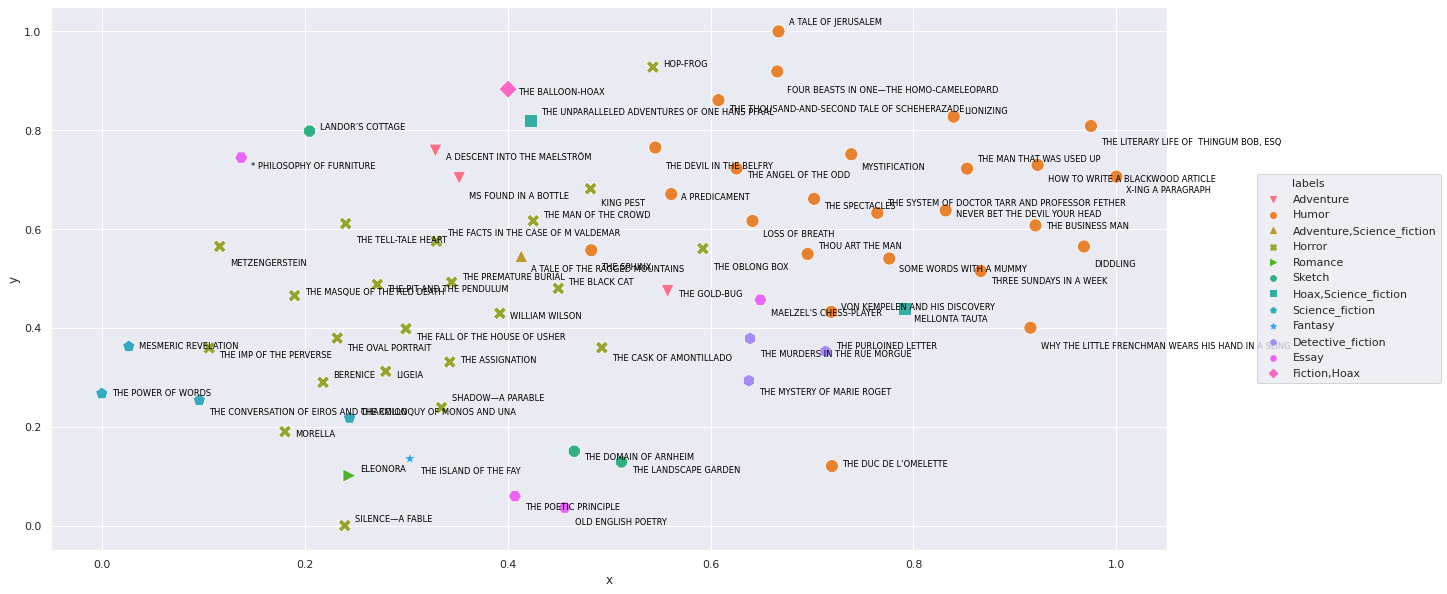

In [24]:
w2v_feature_array.shape
tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2500, random_state=6)
X_2d = tsne_model.fit_transform(w2v_feature_array)

plt.subplots(figsize=(20,10))
from sklearn.preprocessing import MinMaxScaler
X_2d = MinMaxScaler().fit_transform(X_2d)
df= pd.DataFrame({"x":X_2d[:, 0], "y":X_2d[:, 1], "labels":labels, "titles":titles})

markers = ('v', 'o', '^', 'X', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', '<')
ax=sns.scatterplot(data=df, x="x", y="y", hue="labels", style="labels", s=170, markers = markers)
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
     np.random.seed(line + 2)
     ax.text(df.x[line] + 0.01, df.y[line] + np.random.uniform(-0.03, 0.03), 
             df.titles[line], size='small', color='black', weight=540, ha="left", va="top")
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()


## Representing the data semantics with a hierarchical diagram

In [25]:
info = ["%s   (%s)" %(x,y) for x,y in zip(data.title.values, data.classification.values + " - " + data.normalized_date.values)]
info[:5]

['A DESCENT INTO THE MAELSTRÖM   (Adventure - May 1841)',
 'A PREDICAMENT   (Parody - November 1838)',
 'A TALE OF JERUSALEM   (Humor - June 1832)',
 'A TALE OF THE RAGGED MOUNTAINS   (Adventure,Science_fiction - April 1844)',
 'BERENICE   (Horror - March 1835)']

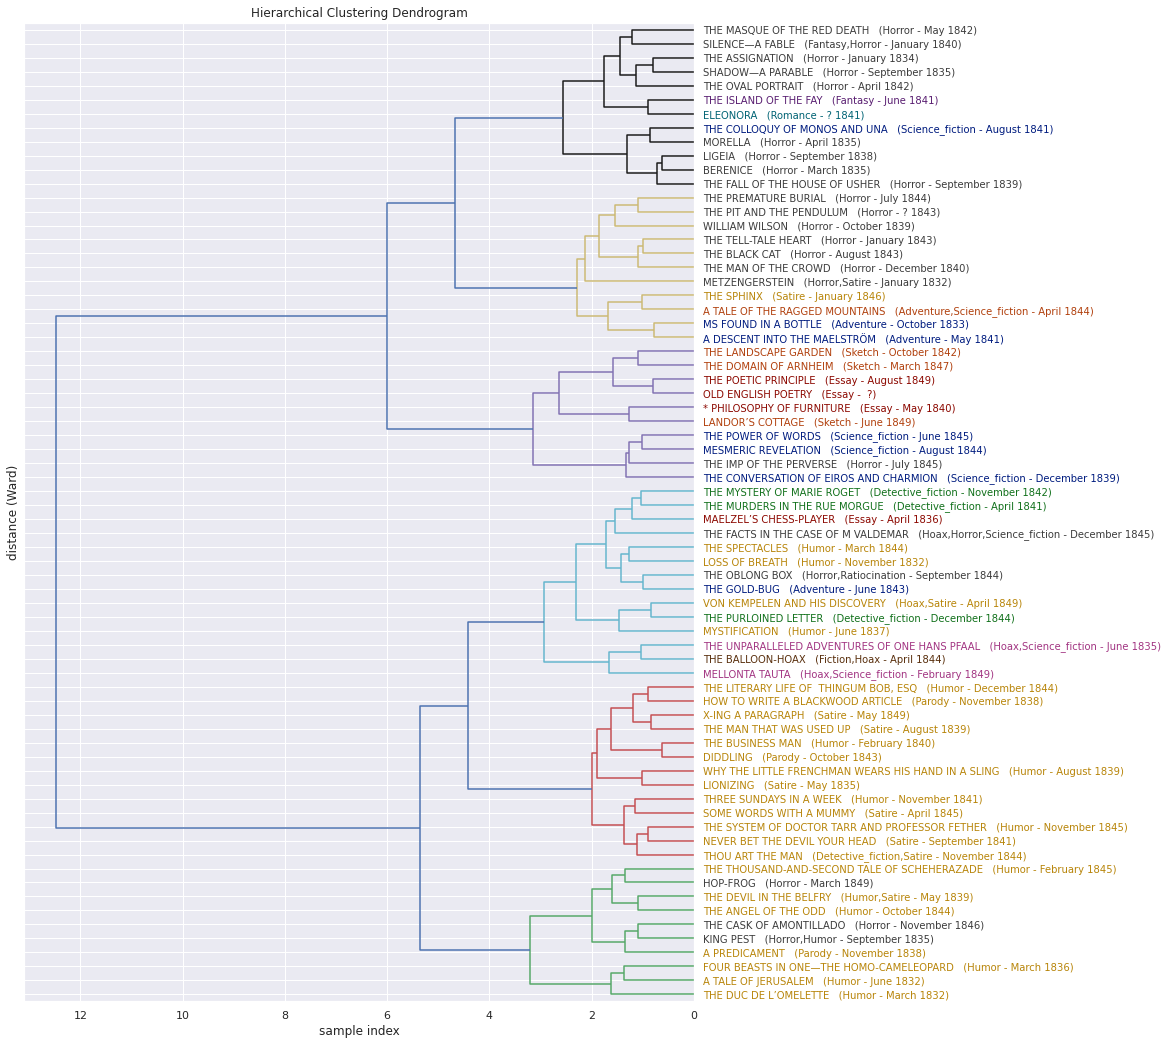

In [26]:

pal=sns.color_palette("dark", n_colors=len(classes))
pal=pal.as_hex()
pal = [pal[i] for i in index]

fig,ax=plt.subplots(figsize=(12, 18))
dd= dendrogram(Z,  labels=info, orientation = "left", leaf_font_size = 10, color_threshold = 4)
pal = [pal[i] for i in dd["leaves"]]
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=0
for lbl in xlbls:
    lbl.set_color(pal[num])
    num+=1

ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_xlabel('sample index')
ax.set_ylabel('distance (Ward)')
plt.show()

## Adding three levels of clustering to the input data

In [27]:
x = ward(Z)
clusters = cut_tree(Z, n_clusters=[2, 4, 6])
data[["level_0", "level_1", "level_2"]] = clusters

### A note for the untagged stories: Maelzel's Chess Player (https://en.wikipedia.org/wiki/Maelzel%27s_Chess_Player,  https://www.eapoe.org/works/essays/maelzel.htm), practically a detective work from Poe, is clustered with some detective fiction stories, and the other untagged works (colored in green), are clustered with sketch stories (https://www.britannica.com/art/literary-sketch).


# 5. Topic modeling via Latent Dirichlet Allocation

## Parts of speech

### One of the clusters seems to be enriched with adjectives, while the other with verbs. I will be removing some structures to perform LDA.

In [28]:
taged_words = [pos_tag(x, "universal") for x in normalized_stories]
word_type = [Counter([y for x,y in z]) for z in taged_words ]
word_classification = pd.DataFrame(word_type, index = titles)
#word_classification["total"] = word_classification.sum(axis=1)
word_classification.fillna(0, inplace=True)
word_classification = word_classification.apply(lambda x: x/x.sum(), axis = 1)
word_classification 


,NOUN,ADJ,ADV,VERB,NUM,ADP,CONJ,PRON,DET,PRT,X
A DESCENT INTO THE MAELSTRÖM,0.464297,0.216122,0.098381,0.149794,0.017455,0.042526,0.001587,0.002539,0.006030,0.000952,0.000317
A PREDICAMENT,0.477086,0.233843,0.091069,0.140423,0.023502,0.028790,0.000588,0.000588,0.003525,0.000588,0.000000
A TALE OF JERUSALEM,0.506259,0.239221,0.066759,0.137691,0.011127,0.022253,0.004172,0.004172,0.002782,0.002782,0.002782
A TALE OF THE RAGGED MOUNTAINS,0.460052,0.265274,0.096606,0.132115,0.009399,0.031332,0.000000,0.001567,0.003133,0.000522,0.000000
BERENICE,0.477454,0.256631,0.096154,0.124668,0.004642,0.034483,0.000000,0.001326,0.003316,0.001326,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
THE BALLOON-HOAX,0.500980,0.238338,0.091729,0.114073,0.023912,0.021168,0.001960,0.001176,0.003920,0.000784,0.001960
THE MYSTERY OF MARIE ROGET,0.491408,0.210667,0.083240,0.152979,0.023655,0.031578,0.000781,0.001339,0.003236,0.000335,0.000781
THE POETIC PRINCIPLE,0.465095,0.255971,0.099510,0.135028,0.010410,0.025720,0.001225,0.002449,0.003674,0.000612,0.000306
THE UNPARALLELED ADVENTURES OF ONE HANS PFAAL,0.460083,0.232744,0.106407,0.145479,0.018692,0.028938,0.001126,0.001126,0.004391,0.000225,0.000788


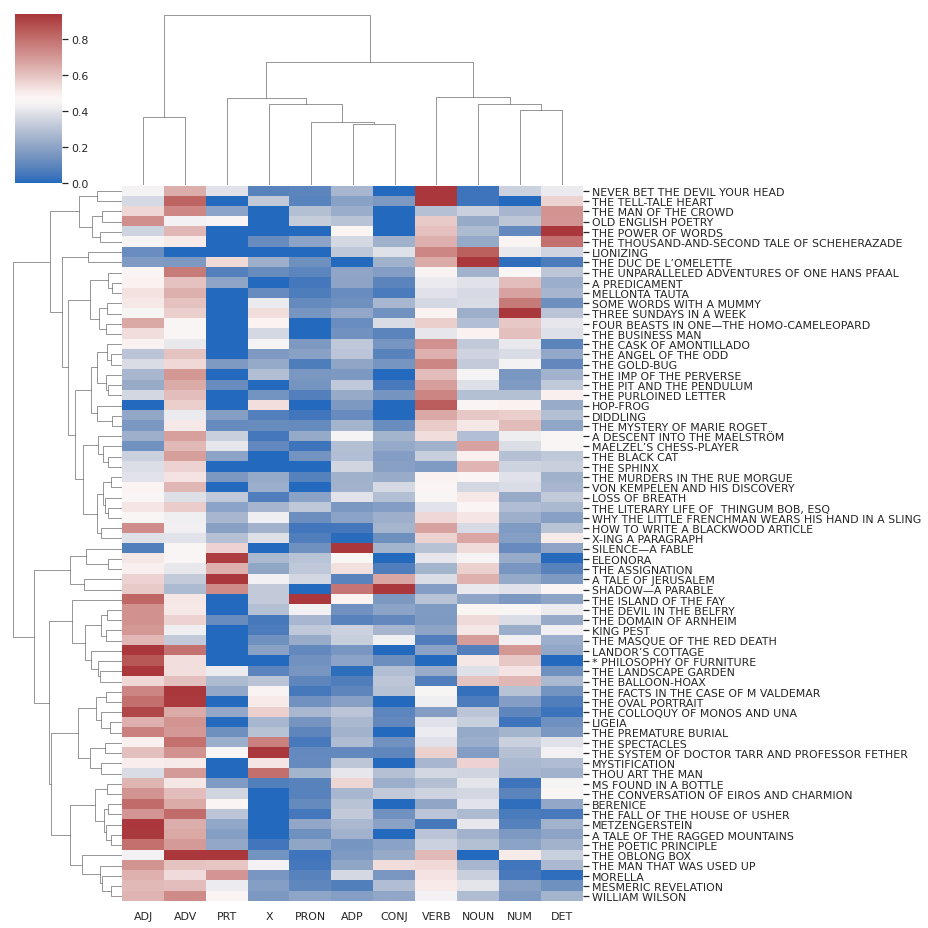

In [29]:
sns.clustermap(word_classification, standard_scale=1, yticklabels=True, robust=True, metric = "euclidean", method = "ward", cmap="vlag", figsize = (13,13))

In [30]:
# LDA 

# filtering grammatical structure

#VERB - verbs (all tenses and modes)
#NOUN - nouns (common and proper)
#PRON - pronouns
#ADJ - adjectives
#ADV - adverbs
#ADP - adpositions (prepositions and postpositions)
#CONJ - conjunctions
#DET - determiners
#NUM - cardinal numbers
#PRT - particles or other function words
#X - other: foreign words, typos, abbreviations
    
filtered = []
for x in normalized_stories:
    tmp = []
    for y,z in pos_tag(x, "universal"):
        if z not in  ["PRON", "ADP", "CONJ", "DET", "PRT", "X"]:
            tmp.append(y)
    filtered.append(tmp)


# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(filtered)

# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in  filtered]

ldamodel = models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20, random_state = 5,  alpha='auto', eta = 'auto', update_every=1, chunksize=100)

## Basic optimization, evaluating the coherence through K potential topics, from 2 to 14

In [31]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(model = ldamodel, dictionary=dictionary, corpus=corpus, texts=filtered, start=2, limit=14, step=1)

Modeling = 2
Coherence: 0.2712425837872136
Modeling = 3
Coherence: 0.28557155933994594
Modeling = 4
Coherence: 0.3017919189199531
Modeling = 5
Coherence: 0.37436531553673114
Modeling = 6
Coherence: 0.3068629780723285
Modeling = 7
Coherence: 0.3715133102507839
Modeling = 8
Coherence: 0.3726498392378137
Modeling = 9
Coherence: 0.36912643847531146
Modeling = 10
Coherence: 0.34767204522678136
Modeling = 11
Coherence: 0.35905699943831676
Modeling = 12
Coherence: 0.37004153605761186
Modeling = 13
Coherence: 0.33884898308585903


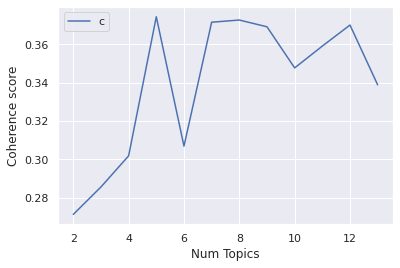

In [32]:
# Show graph
plot_coherence(coherence_values, 2, 14, 1)

## 10 main words per topic

In [33]:
#optimal_model = model_list[np.argmax(coherence_values)]
optimal_model = model_list[6] # I am choosing K = 8, it is a stable point as shown by the plot, and with an interesting diversity of topics
model_topics = optimal_model.show_topics(formatted=False)
for i in optimal_model.print_topics(num_words=10):
    print(i)

(0, '0.011*"balloon" + 0.006*"sea" + 0.006*"car" + 0.005*"ship" + 0.005*"surface" + 0.004*"moon" + 0.004*"mile" + 0.004*"atmosphere" + 0.003*"distance" + 0.003*"apparent"')
(1, '0.006*"bon" + 0.005*"shadow" + 0.004*"chamber" + 0.003*"horror" + 0.003*"terror" + 0.003*"apartment" + 0.003*"memory" + 0.003*"sir" + 0.003*"figure" + 0.003*"struggle"')
(2, '0.006*"king" + 0.005*"beauty" + 0.005*"hundred" + 0.004*"poem" + 0.004*"art" + 0.004*"write" + 0.003*"nose" + 0.003*"love" + 0.003*"poet" + 0.003*"captain"')
(3, '0.008*"pompey" + 0.007*"big" + 0.006*"monsieur" + 0.006*"angel" + 0.006*"system" + 0.006*"clock" + 0.005*"lady" + 0.005*"table" + 0.005*"odd" + 0.004*"bottle"')
(4, '0.009*"valley" + 0.009*"rock" + 0.009*"river" + 0.006*"tree" + 0.006*"love" + 0.006*"shadow" + 0.005*"lily" + 0.005*"sigh" + 0.005*"impulse" + 0.005*"grass"')
(5, '0.007*"tree" + 0.007*"jupiter" + 0.004*"skull" + 0.003*"spot" + 0.003*"table" + 0.003*"direction" + 0.003*"horse" + 0.003*"seat" + 0.003*"main" + 0.003*"d

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.065320 -0.009782       1        1  22.617846
7      0.085986 -0.047604       2        1  22.136936
2     -0.000520  0.064777       3        1  19.862715
0      0.012838 -0.098955       4        1  13.424797
5      0.010190 -0.016599       5        1  10.085591
3      0.108765  0.129688       6        1   5.167784
6      0.059224 -0.050754       7        1   4.156846
4     -0.211163  0.029229       8        1   2.547487, topic_info=         Term        Freq       Total Category  logprob  loglift
2397  balloon  105.000000  105.000000  Default  30.0000  30.0000
1081    river   85.000000   85.000000  Default  29.0000  29.0000
605    shadow   99.000000   99.000000  Default  28.0000  28.0000
720      tree  101.000000  101.000000  Default  27.0000  27.0000
412      love  103.000000  103.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
685       sun    7.266571   69.269987   Topic8  -5.5270   1.4153
942     green    6.327780   48.835019   Topic8  -5.6654   1.6266
442      moon    6.622989   56.827523   Topic8  -5.6198   1.5206
214     dream    7.467469   89.763503   Topic8  -5.4998   1.1834
2146     star    5.724274   52.170002   Topic8  -5.7656   1.4603

[514 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2711      1  0.820559   academy
2711      2  0.136760   academy
5         1  0.063211  accident
5         2  0.268648  accident
5         3  0.142225  accident
...     ...       ...       ...
767       7  0.028567      yard
768       1  0.228692      yell
768       4  0.076231      yell
768       5  0.152461      yell
768       6  0.457384      yell

[2037 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 3, 1, 6, 4, 7, 5])

## The final output

In [35]:
df_topic = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=info)
data[["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]] = df_topic[["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]]
data.to_csv("final_data.csv", index=False)
data

,title,text,wikipedia_title,publication_date,first_published_in,classification,notes,normalized_date,level_0,level_1,level_2,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,A DESCENT INTO THE MAELSTRÖM,"The ways of God in Nature, as in Providence, a...",A Descent into the Maelström,May 1841,Graham's Magazine,Adventure,?,May 1841,0,0,0,0.0,0.9998,"balloon, sea, car, ship, surface, moon, mile, ..."
1,A PREDICAMENT,"What chance, good lady, hath bereft you thus? ...",A Predicament,November 1838,Baltimore American Museum,Parody,"Companion to ""How to Write a Blackwood Article...",November 1838,1,1,1,3.0,0.9996,"pompey, big, monsieur, angel, system, clock, l..."
2,A TALE OF JERUSALEM,Intensos rigidarn in frontern ascendere canos ...,A Tale of Jerusalem,"June 9, 1832",Philadelphia Saturday Courier,Humor,?,June 1832,1,1,1,0.0,0.4810,"balloon, sea, car, ship, surface, moon, mile, ..."
3,A TALE OF THE RAGGED MOUNTAINS,"DURING the fall of the year 1827, while residi...",A Tale of the Ragged Mountains,April 1844,Godey's Lady's Book,"Adventure,Science_fiction",?,April 1844,0,0,0,5.0,0.9248,"tree, jupiter, skull, spot, table, direction, ..."
4,BERENICE,"Dicebant mihi sodales, si sepulchrum amicae vi...",Berenice,March 1835,Southern Literary Messenger,Horror,?,March 1835,0,0,2,1.0,0.9039,"bon, shadow, chamber, horror, terror, apartmen..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,THE BALLOON-HOAX,"[Astounding News by Express, via Norfolk!—The ...",?,"April 13, 1844",?,"Fiction,Hoax",?,April 1844,1,2,5,0.0,0.9998,"balloon, sea, car, ship, surface, moon, mile, ..."
66,THE MYSTERY OF MARIE ROGET,A SEQUEL TO “THE MURDERS IN THE RUE MORGUE.” ...,?,November 1842,?,Detective_fiction,?,November 1842,1,2,5,7.0,0.9999,"corpse, box, paper, letter, madame, murder, ar..."
67,THE POETIC PRINCIPLE,"IN speaking of the Poetic Principle, I have no...",?,"August 17, 1849",?,Essay,?,August 1849,0,3,4,2.0,0.7872,"king, beauty, hundred, poem, art, write, nose,..."
68,THE UNPARALLELED ADVENTURES OF ONE HANS PFAAL,"BY late accounts from Rotterdam, that city see...",?,June 1835,?,"Hoax,Science_fiction",?,June 1835,1,2,5,0.0,0.9999,"balloon, sea, car, ship, surface, moon, mile, ..."


# 6. KNN clustering of the Word2vec matrix

In [36]:
neigh = NearestNeighbors(n_neighbors=4, metric='cosine')
neigh.fit(w2v_feature_array)
A = neigh.kneighbors_graph(w2v_feature_array).toarray()
np.fill_diagonal(A, 0)

In [37]:
titles = np.array(titles)
out = []
for i in range(len(titles)):
  out.append(np.array(titles)[A[i].astype("bool")])

## Recommendations (three per story)

In [38]:

recommended = pd.DataFrame(out, index= titles)
recommended.sort_index()
recommended = pd.DataFrame(recommended.values, info)
recommended.to_csv("recommended.csv", index=True)
with pd.option_context('display.max_rows', 100):
    display(recommended)


,0,1,2
A DESCENT INTO THE MAELSTRÖM (Adventure - May 1841),MS FOUND IN A BOTTLE,THE PIT AND THE PENDULUM,THE UNPARALLELED ADVENTURES OF ONE HANS PFAAL
A PREDICAMENT (Parody - November 1838),LOSS OF BREATH,THE ANGEL OF THE ODD,THE DEVIL IN THE BELFRY
A TALE OF JERUSALEM (Humor - June 1832),ELEONORA,FOUR BEASTS IN ONE—THE HOMO-CAMELEOPARD,THE ASSIGNATION
"A TALE OF THE RAGGED MOUNTAINS (Adventure,Science_fiction - April 1844)",THE MAN OF THE CROWD,THE PREMATURE BURIAL,THE SPHINX
BERENICE (Horror - March 1835),LIGEIA,MORELLA,THE FALL OF THE HOUSE OF USHER
DIDDLING (Parody - October 1843),NEVER BET THE DEVIL YOUR HEAD,THE BUSINESS MAN,THE SYSTEM OF DOCTOR TARR AND PROFESSOR FETHER
ELEONORA (Romance - ? 1841),LIGEIA,MORELLA,THE ISLAND OF THE FAY
FOUR BEASTS IN ONE—THE HOMO-CAMELEOPARD (Humor - March 1836),A TALE OF JERUSALEM,LIONIZING,THE THOUSAND-AND-SECOND TALE OF SCHEHERAZADE
HOP-FROG (Horror - March 1849),THE CASK OF AMONTILLADO,THE SYSTEM OF DOCTOR TARR AND PROFESSOR FETHER,THE THOUSAND-AND-SECOND TALE OF SCHEHERAZADE
HOW TO WRITE A BLACKWOOD ARTICLE (Parody - November 1838),THE BUSINESS MAN,THE MAN THAT WAS USED UP,X-ING A PARAGRAPH


Notes

<sup> 1 </sup> This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org